# Twitter Sentiment Analysis

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re

import warnings
warnings.filterwarnings('ignore')

In [30]:
data = pd.read_csv('data/train.csv')

In [31]:
data

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


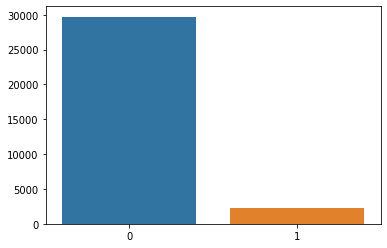

In [32]:
class_dict = {
    0: (data.label == 0).sum(),
    1: (data.label == 1).sum(),
}

sns.barplot(list(class_dict.keys()), list(class_dict.values()))

In [33]:
print(data.tweet.loc[90])

 @user offline now after a very nice and long night.. ð #snapchat @user   #redhead #vermillionred 


## Pre-processamento

Ao analisar algumas frases, notei que existem caracteres especiais e emojis que precisam ser removidos para a classificação e as hashtags podem ser deixadas a parte para um ver se tem alguma relação o comentário com ser ou não preconceituoso

In [34]:
import nltk
import regex as re

lemma = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords

nltk.download('stopwords') #to use stopwords func
nltk.download('wordnet') #to use lemma func

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
def normalize_text(input):
    text = " ".join(filter(lambda x: x[0]!= '@' , input.split()))
    text = re.sub('[^a-zA-Z]', ' ', text) #use regex to match anything that's not a word
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in set(stopwords.words('english'))] #remove connections words
    text = [lemma.lemmatize(word) for word in text] #return the word to it's base form | Caring -> Care
    text = " ".join(text)
    return text

def normalize_hashtag(input):
    hashtags = " ".join(filter(lambda x: x[0]== '#', input.split()))
    hashtags = re.sub('[^a-zA-Z]', ' ', hashtags) #use regex to match anything that's not a word
    hashtags = hashtags.lower()
    hashtags = hashtags.split()
    hashtags = [lemma.lemmatize(word) for word in hashtags] #return the word to it's base form | Caring -> Care
    hashtags = " ".join(hashtags)
    return hashtags

In [36]:
data['text'] = data.tweet.apply(normalize_text)
data['hashtag'] = data.tweet.apply(normalize_hashtag)

In [37]:
data

,id,label,tweet,text,hashtag
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...,run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked
2,3,0,bihday your majesty,bihday majesty,
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur,model
4,5,0,factsguide: society now #motivation,factsguide society motivation,motivation
...,...,...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...,ate isz youuu,
31958,31959,0,to see nina turner on the airwaves trying to...,see nina turner airwave trying wrap mantle gen...,shame imwithher
31959,31960,0,listening to sad songs on a monday morning otw...,listening sad song monday morning otw work sad,
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...",sikh temple vandalised calgary wso condemns act,sikh temple calgary wso


## EDA

Esta seção é para entender melhor o dado e ver qual das duas features: *text* ou *hashtag* poderão ser usadas para a classificação

In [38]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [39]:
neutral_words = " ".join(data.text)
hated_word = " ".join(data.text[data.label == 1])

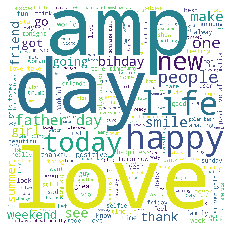

In [40]:
wordcloud = WordCloud(height=2000, width=2000, stopwords=STOPWORDS, background_color='white')
wordcloud = wordcloud.generate(neutral_words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

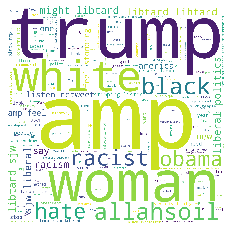

In [41]:
wordcloud = WordCloud(height=2000, width=2000, stopwords=STOPWORDS, background_color='white')
wordcloud = wordcloud.generate(hated_word)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [42]:
data.hashtag[data.hashtag == ''].count()

8693

## Escolha das Features

Como visto anteriormente, usar a feature *text* é a melhor opção quando comparado as *hashtags* (pois existem *tweets* que não tem nenhuma), contudo, um classificador só consegue trabalhar com números. Para atingir tal objetivo, escolhi usar uma técnica chamada *bag of words*, que dá uma chave a cada termo presente na string. 

Para normalizar a ocorrencia de cada palavra, existe o *TFIDF*, que aplica uma normalização que equilibra o peso dos termos para cada corpo textual.

In [43]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [44]:
vectorizer = CountVectorizer()
transformer = TfidfTransformer(smooth_idf=False)

X = vectorizer.fit_transform(data['text'])
X = vectorizer.transform(data.text)
tfidf = transformer.fit_transform(X)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, data.label, test_size=0.33, random_state=42)

## Criação do Modelo

Esta seção é dedicada a encontrar o classificador que tenha os melhores resultados baseados nas *classification_report* do *sklearn* que mostra a **precisão**, **revocação** e o **f1_score** (média harmônica entre seus anteriores).

Nos classificadores *Logistic Regression* busquei alterar a variável C, para ver se havia algum caso que melhoraria os resultados. Por fim, por conta do desbalanceamento das classes, uso o parâmetro *class_weight='balanced'*, que busca atribuir pesos que melhorem os resultados baseados na quantidaded de amostrar de cada uma.

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [47]:
model_lsvc = LinearSVC()
_ = model_lsvc.fit(X_train, y_train)

model_lr1 = LogisticRegression(C=10)
_ = model_lr1.fit(X_train, y_train)

model_lr2 = LogisticRegression(C=100)
_ = model_lr2.fit(X_train, y_train)

model_lr3 = LogisticRegression(C=100, class_weight='balanced')
_ = model_lr3.fit(X_train, y_train)

In [48]:
models = {
    0: model_lsvc,
    1: model_lr1,
    2: model_lr2,
    3: model_lr3,
}

title = {
    0: "Linear SVC",
    1: "Logistic Regression with C = 10",
    2: "Logistic Regression with C = 100",
    3: "Logistic Regression with C = 100 and balanced class weights",
}

In [49]:
bigger = 0
model = 0
chosed = 0

for key in models:
    pred = models[key].predict(X_test)
    
    print('---------------------------{}---------------------------'.format(title[key]))
    print('\n')
    print(classification_report(y_test, pred))
    print('\n')
    
    if (bigger < f1_score(y_test, pred)):
        model = models[key]
        bigger = f1_score(y_test, pred)
        chosed = key

---------------------------Linear SVC---------------------------


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9806
           1       0.88      0.54      0.67       742

    accuracy                           0.96     10548
   macro avg       0.93      0.77      0.82     10548
weighted avg       0.96      0.96      0.96     10548



---------------------------Logistic Regression with C = 10---------------------------


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      9806
           1       0.88      0.49      0.63       742

    accuracy                           0.96     10548
   macro avg       0.92      0.74      0.80     10548
weighted avg       0.96      0.96      0.95     10548



---------------------------Logistic Regression with C = 100---------------------------


              precision    recall  f1-score   support

           0       0.97      0.99      0.98

In [50]:
print("Best option is {}".format(title[chosed]))

Best option is Logistic Regression with C = 100 and balanced class weights


## Treinamento

Esta seção usa o modelo escolhido e treinado anteriormente com o dataset de teste para aferir a precisão. Para tentar mensurar a precisão da predição é usado o *predict_proba* 

In [51]:
test = pd.read_csv('data/test.csv')

In [52]:
test['text'] = test.tweet.apply(normalize_text)
test

,id,tweet,text
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...
1,31964,@user #white #supremacists want everyone to s...,white supremacist want everyone see new bird m...
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe way heal acne altwaystoheal healthy healing
3,31966,is the hp and the cursed child book up for res...,hp cursed child book reservation already yes h...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",rd bihday amazing hilarious nephew eli ahmir u...
...,...,...,...
17192,49155,thought factory: left-right polarisation! #tru...,thought factory left right polarisation trump ...
17193,49156,feeling like a mermaid ð #hairflip #neverre...,feeling like mermaid hairflip neverready forma...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...,hillary campaigned today ohio omg amp used wor...
17195,49158,"happy, at work conference: right mindset leads...",happy work conference right mindset lead cultu...


In [53]:
test_tokenize = vectorizer.fit_transform(data.text) #use the same word set of training
test_tokenize = vectorizer.transform(test.text) 
test_tfidf = transformer.fit_transform(test_tokenize)

In [54]:
pred = model.predict(test_tfidf)
prob = model.predict_proba(test_tfidf)

In [55]:
test['label'] = pred

scores = (prob[:,1] >= 0.5).astype(int) #Probility that represents it belonging to a class 
test['score'] = scores

In [56]:
test[test['label'] == 1 ]

,id,tweet,text,label,score
19,31982,thought factory: bbc neutrality on right wing ...,thought factory bbc neutrality right wing fasc...,1,1
26,31989,chick gets fucked hottest naked lady,chick get fucked hottest naked lady,1,1
33,31996,suppo the #taiji fisherman! no bullying! no ra...,suppo taiji fisherman bullying racism tweet ta...,1,1
110,32073,hey @user - a $14000 ivanka bracelet? do you f...,hey ivanka bracelet feel good profiting xenoph...,1,1
140,32103,@user all together this christmas: pls &amp; ...,together christmas pls amp follow national day...,1,1
...,...,...,...,...,...
17128,49091,@user the uk governmentâs new #anti-semitism...,uk government new anti semitism definition con...,1,1
17148,49111,we grew up fucked upð¤ its fucked upð¥ i'm...,grew fucked fucked believing better place fucking,1,1
17176,49139,@user @user are the most racist pay ever!!!!!,racist pay ever,1,1
17188,49151,"black professor demonizes, proposes nazi style...",black professor demonizes proposes nazi style ...,1,1
